In [ ]:
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils
mp_styles  = mp.solutions.drawing_styles

cap = cv2.VideoCapture(0, cv2.CAP_DSHOW)
if not cap.isOpened():
    raise RuntimeError("❌ وب‌کم باز نشد.")

FRAME_W = 960
cap.set(cv2.CAP_PROP_FRAME_WIDTH, FRAME_W)

with mp_hands.Hands(
    model_complexity=0,        # سریع‌تر
    max_num_hands=1,           # MVP: یک دست
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5
) as hands:
    while True:
        ok, frame = cap.read()
        if not ok: break
        frame = cv2.flip(frame, 1)
        h, w = frame.shape[:2]

        rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        rgb.flags.writeable = False
        res = hands.process(rgb)
        rgb.flags.writeable = True

        if res.multi_hand_landmarks:
            for hand_lms, handedness in zip(res.multi_hand_landmarks, res.multi_handedness):
                mp_drawing.draw_landmarks(
                    frame,
                    hand_lms,
                    mp_hands.HAND_CONNECTIONS,
                    mp_styles.get_default_hand_landmarks_style(),
                    mp_styles.get_default_hand_connections_style()
                )
                label = handedness.classification[0].label  # 'Left' یا 'Right'
                score = handedness.classification[0].score
                cv2.putText(frame, f"{label} ({score:.2f})", (10, 30),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.8, (50, 240, 50), 2)
        else:
            cv2.putText(frame, "No hand", (10, 30),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0,0,255), 2)

        cv2.imshow("Hands — live landmarks", frame)
        k = cv2.waitKey(1) & 0xFF
        if k in (ord('q'), ord('Q')):
            break

cap.release()
cv2.destroyAllWindows()


In [ ]:
mp_hands = mp.solutions.hands

cap = cv2.VideoCapture(0, cv2.CAP_DSHOW)
cap.set(cv2.CAP_PROP_FRAME_WIDTH, FRAME_W)

with mp_hands.Hands(
    model_complexity=0,
    max_num_hands=1,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5
) as hands:
    while True:
        ok, frame = cap.read()
        if not ok: break
        frame = cv2.flip(frame, 1)
        h, w = frame.shape[:2]

        rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        res = hands.process(rgb)

        if res.multi_hand_landmarks:
            hand_lms = res.multi_hand_landmarks[0]
            label = res.multi_handedness[0].classification[0].label  # Left/Right
            feat = make_feature_vector(hand_lms, label, w, h)

            # نمایش خلاصه
            cv2.putText(frame, f"feat_dim={feat.shape[0]}", (10, 30),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.8, (50, 240, 50), 2)
        else:
            cv2.putText(frame, "No hand", (10, 30),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0,0,255), 2)

        cv2.imshow("Hands — features preview", frame)
        k = cv2.waitKey(1) & 0xFF
        if k in (ord('q'), ord('Q')):
            break

cap.release()
cv2.destroyAllWindows()


In [2]:
import cv2, time, math, sys
import numpy as np
from collections import deque
import mediapipe as mp
from matplotlib import pyplot as plt

print("OpenCV:", cv2.__version__)
print("MediaPipe:", mp.__version__)


OpenCV: 4.12.0
MediaPipe: 0.10.14


In [3]:
# اندیس‌های مهم انگشت‌ها طبق MediaPipe:
WRIST = 0
FINGERTIPS = [4, 8, 12, 16, 20]              # سرانگشت‌ها (شست تا کوچک)
MCPs = [2, 5, 9, 13, 17]                     # مفصل MCP هر انگشت
PIP  = [3, 6, 10, 14, 18]                    # مفصل PIP
DIP  = [None, 7, 11, 15, 19]                 # DIP (شست DIP ندارد؛ None)

def landmarks_to_np(hand_lms, w, h):
    """به آرایه‌ی (21,3) در مقیاس پیکسلی تبدیل می‌کند."""
    pts = []
    for lm in hand_lms.landmark:
        pts.append([lm.x * w, lm.y * h, lm.z * w])  # z را هم در همان مقیاس x می‌بریم
    return np.array(pts, dtype=np.float32)

def mirror_if_left(pts, label, w):
    """اگر دست چپ بود، آینه افقی می‌کنیم تا با راست هم‌شکل شود."""
    if label.lower().startswith('left'):
        pts = pts.copy()
        pts[:,0] = w - pts[:,0]
    return pts

def normalize_by_palm(pts):
    """
    مبدأ = WRIST، مقیاس = فاصله WRIST تا MCP وسط (انگشت سوم، idx=9)
    """
    p = pts.copy()
    origin = p[WRIST].copy()
    p -= origin

    scale_ref = np.linalg.norm(p[9]) + 1e-6  # MCP انگشت وسط
    p /= scale_ref
    return p

def pairwise_distances(pts, idx_list):
    """فواصل جفتی برخی نقاط کلیدی (برای کنترل اندازه‌ی بردار محدود نگه می‌داریم)."""
    sel = pts[idx_list]  # (K,3)
    D = []
    for i in range(len(sel)):
        for j in range(i+1, len(sel)):
            D.append(np.linalg.norm(sel[i,:2]-sel[j,:2]))  # فقط x,y
    return np.array(D, dtype=np.float32)

def finger_angles(pts):
    """
    زوایای هر انگشت نسبت به محور x (با arctan2)، برای 5 انگشت (از MCP→tip).
    """
    ang = []
    chains = [
        [WRIST, 2, 3, 4],     # thumb approx
        [0, 5, 6, 8],         # index
        [0, 9, 10, 12],       # middle
        [0, 13, 14, 16],      # ring
        [0, 17, 18, 20],      # pinky
    ]
    for ch in chains:
        v = pts[ch[-1],:2] - pts[ch[1],:2]
        ang.append(math.atan2(v[1], v[0]))
    return np.array(ang, dtype=np.float32)

KEY_IDX = [WRIST] + FINGERTIPS + MCPs  # 1 + 5 + 5 = 11 نقطه برای فواصل جفتی

def make_feature_vector(hand_lms, handedness_label, w, h):
    """
    بردار ویژگی نهایی:
    - مختصات نرمال‌شده 21×2 (x,y) → 42
    - فواصل جفتی از 11 نقطه کلیدی (x,y) → 55
    - زوایا برای 5 انگشت → 5
    کل ≈ 102 بُعد (سبک و سریع)
    """
    pts = landmarks_to_np(hand_lms, w, h)
    pts = mirror_if_left(pts, handedness_label, w)
    pts = normalize_by_palm(pts)

    xy = pts[:, :2].reshape(-1)                         # 21*2 = 42
    dists = pairwise_distances(pts, KEY_IDX)            # C(11,2)=55
    angs  = finger_angles(pts)                          # 5

    feat = np.concatenate([xy, dists, angs], axis=0)    # ~102 dims
    return feat.astype(np.float32)


In [4]:
import cv2, time, math, os, numpy as np, mediapipe as mp
from collections import defaultdict, deque

# اگر از مرحله ۱ این‌ها را داری، دوباره لازم نیست؛ اما مطمئن شو موجودند:
# make_feature_vector(hand_lms, handedness_label, w, h)

SAVE_PATH = r"C:\Users\Saeid_Eshghi\Project_10\sign_digits_user.npz"  # مسیر دلخواه
MIN_SAMPLES_PER_CLASS = 30     # هدف اولیه (می‌تونی کمتر/بیشتر کنی)

# کلاس‌ها: 1..9 و 10  (بدون صفر)
CLASS_LABELS = list(range(1, 11))   # [1,2,3,4,5,6,7,8,9,10]

# نگهداری داده‌ها در حافظه
X = defaultdict(list)    # label -> list of feature vectors
H = defaultdict(list)    # label -> list of handedness ("Right"/"Left") برای بازرسی
HISTORY = deque(maxlen=1000)  # تاریخچه آخرین ثبت‌ها برای Undo

# قوانین دست:
def required_hand_for_label(label: int) -> str:
    """1..5 → Right, 6..10 → Left"""
    return "Right" if 1 <= label <= 5 else "Left"

# نمایش شمارش‌ها به‌صورت رشته
def counts_str():
    parts = []
    for lbl in CLASS_LABELS:
        parts.append(f"{lbl}:{len(X[lbl])}")
    return "  ".join(parts)


In [5]:
mp_hands = mp.solutions.hands
mp_draw  = mp.solutions.drawing_utils
mp_style = mp.solutions.drawing_styles

cap = cv2.VideoCapture(0, cv2.CAP_DSHOW)
if not cap.isOpened():
    raise RuntimeError("❌ وب‌کم باز نشد.")

FRAME_W = 960
cap.set(cv2.CAP_PROP_FRAME_WIDTH, FRAME_W)

info_msg = ""       # پیام کوتاه برای کاربر (بالا سمت چپ)
info_t0 = 0
INFO_MS = 1200      # چند میلی‌ثانیه پیام بماند

def flash(msg):
    global info_msg, info_t0
    info_msg = msg
    info_t0 = time.time()

def save_dataset():
    # ساخت آرایه‌های یکنواخت
    all_X = []
    all_y = []
    all_h = []
    for lbl in CLASS_LABELS:
        feats = X[lbl]
        for f in feats:
            all_X.append(f)
            all_y.append(lbl)
            all_h.append(lbl <= 5 and "Right" or "Left")
    if not all_X:
        flash("⚠️ هنوز داده‌ای نیست.")
        return
    all_X = np.stack(all_X).astype(np.float32)
    all_y = np.array(all_y, dtype=np.int32)
    np.savez_compressed(SAVE_PATH, X=all_X, y=all_y)
    flash(f"✅ ذخیره شد: {SAVE_PATH}  (نمونه‌ها: {len(all_y)})")

def undo_last():
    if not HISTORY:
        flash("چیزی برای Undo نیست.")
        return
    lbl = HISTORY.pop()
    if X[lbl]:
        X[lbl].pop()
        H[lbl].pop() if H[lbl] else None
    flash(f"Undo → کلاس {lbl} (اکنون {len(X[lbl])})")


with mp_hands.Hands(
    model_complexity=0,
    max_num_hands=1,
    min_detection_confidence=0.6,
    min_tracking_confidence=0.6
) as hands:
    while True:
        ok, frame = cap.read()
        if not ok: break
        frame = cv2.flip(frame, 1)
        h, w = frame.shape[:2]

        rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        rgb.flags.writeable = False
        res = hands.process(rgb)
        rgb.flags.writeable = True

        detected = False
        hand_label = None
        feat = None

        if res.multi_hand_landmarks:
            detected = True
            hand_lms = res.multi_hand_landmarks[0]
            hand_label = res.multi_handedness[0].classification[0].label  # 'Left' یا 'Right'

            # رسم لاندمارک‌ها
            mp_draw.draw_landmarks(
                frame, hand_lms, mp_hands.HAND_CONNECTIONS,
                mp_style.get_default_hand_landmarks_style(),
                mp_style.get_default_hand_connections_style()
            )

            # استخراج ویژگی
            feat = make_feature_vector(hand_lms, hand_label, w, h)

        # HUD: دستورالعمل و شمارش‌ها
        cv2.putText(frame, "Collect samples: 1..9 = class 1..9  |  0 = class 10",
                    (10, 26), cv2.FONT_HERSHEY_SIMPLEX, 0.65, (220,255,220), 2)
        cv2.putText(frame, "Rules: Right hand -> 1..5    Left hand -> 6..10",
                    (10, 52), cv2.FONT_HERSHEY_SIMPLEX, 0.65, (220,220,255), 2)
        cv2.putText(frame, f"Counts: {counts_str()}",
                    (10, 78), cv2.FONT_HERSHEY_SIMPLEX, 0.65, (255,220,220), 2)
        cv2.putText(frame, "[S] Save   [U] Undo   [C] Clear a class   [Q] Quit",
                    (10, h-10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (200,200,200), 2)

        # پیام کوتاه
        if info_msg and (time.time() - info_t0) < (INFO_MS/1000.0):
            cv2.putText(frame, info_msg, (10, 110), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (40,255,40), 2)

        # وضعیت دست
        if detected:
            cv2.putText(frame, f"Detected: {hand_label}", (w-230, 26),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.65, (50,240,50), 2)
        else:
            cv2.putText(frame, "No hand", (w-150, 26),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,0,255), 2)

        cv2.imshow("Digits Collector (1..9, 0→10) — Right=1..5, Left=6..10", frame)
        k = cv2.waitKey(1) & 0xFF

        if k in (ord('q'), ord('Q')):
            break

        elif k in (ord('s'), ord('S')):
            save_dataset()

        elif k in (ord('u'), ord('U')):
            undo_last()

        elif k in (ord('c'), ord('C')):
            # پاک کردن یک کلاس خاص
            try:
                lbl_str = input("شماره کلاسی که پاک شود؟ (1..10): ").strip()
                lbl = int(lbl_str)
                if lbl in CLASS_LABELS:
                    X[lbl].clear(); H[lbl].clear()
                    flash(f"کلاس {lbl} پاک شد.")
                else:
                    flash("کلاس نامعتبر.")
            except Exception:
                flash("ورودی نامعتبر.")

        # ثبت نمونه‌ها با کلیدهای 1..9 و 0(=10)
        elif k in [ord(str(d)) for d in range(10)]:
            if not detected or feat is None:
                flash("⛔ اول دستت شناسایی بشه بعد ثبت کن.")
                continue

            key_char = chr(k)
            lbl = 10 if key_char == '0' else int(key_char)

            if lbl not in CLASS_LABELS:
                flash("کلاس مجاز نیست.")
                continue

            need = required_hand_for_label(lbl)  # 'Right' یا 'Left'
            if need.lower() != hand_label.lower():
                flash(f"⛔ برای کلاس {lbl} باید دست {need} باشد (الان: {hand_label}).")
                continue

            X[lbl].append(feat)
            H[lbl].append(hand_label)
            HISTORY.append(lbl)
            flash(f"✅ ثبت شد: کلاس {lbl}  (کل: {len(X[lbl])})")

cap.release()
cv2.destroyAllWindows()


D:\01\Soft\anaconda3\envs\headmouse_py310\lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


In [ ]:
pip install scikit-learn


In [6]:
import numpy as np
from collections import Counter

SAVE_PATH = r"C:\Users\Saeid_Eshghi\Project_10\sign_digits_user.npz"

data = np.load(SAVE_PATH)
X = data['X'].astype(np.float32)   # (N, D)
y = data['y'].astype(np.int32)     # (N,)

print("Shapes:", X.shape, y.shape)
print("Class counts:", dict(Counter(y)))
assert set(np.unique(y)) <= set(range(1, 11)), "فقط کلاس‌های 1..10 باید باشند."


Shapes: (1055, 102) (1055,)
Class counts: {np.int32(1): 103, np.int32(2): 108, np.int32(3): 121, np.int32(4): 115, np.int32(5): 50, np.int32(6): 101, np.int32(7): 100, np.int32(8): 120, np.int32(9): 118, np.int32(10): 119}


In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_val_sc   = scaler.transform(X_val)

print("Train:", X_train_sc.shape, "Val:", X_val_sc.shape)


Train: (844, 102) Val: (211, 102)


In [8]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

svm = SVC(kernel='rbf', C=5.0, gamma='scale', probability=True, random_state=42)
svm.fit(X_train_sc, y_train)

y_val_pred = svm.predict(X_val_sc)
val_acc = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {val_acc:.3f}")

print("\nClassification Report:")
print(classification_report(y_val, y_val_pred, digits=3))


Validation Accuracy: 1.000

Classification Report:
              precision    recall  f1-score   support

           1      1.000     1.000     1.000        21
           2      1.000     1.000     1.000        21
           3      1.000     1.000     1.000        24
           4      1.000     1.000     1.000        23
           5      1.000     1.000     1.000        10
           6      1.000     1.000     1.000        20
           7      1.000     1.000     1.000        20
           8      1.000     1.000     1.000        24
           9      1.000     1.000     1.000        24
          10      1.000     1.000     1.000        24

    accuracy                          1.000       211
   macro avg      1.000     1.000     1.000       211
weighted avg      1.000     1.000     1.000       211



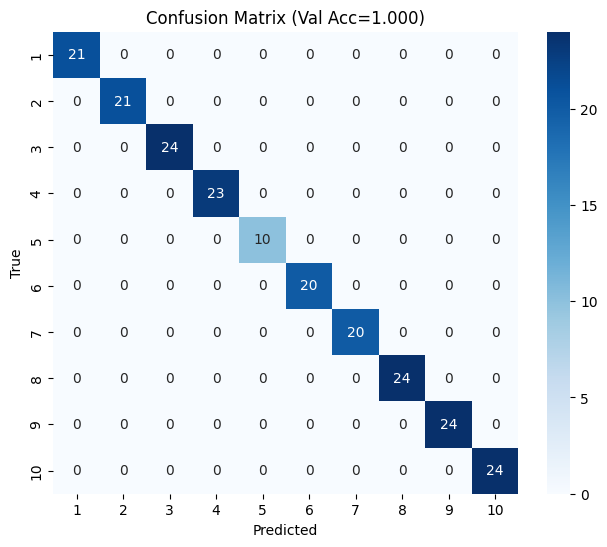

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns  # اگر نداری: pip install seaborn

cm = confusion_matrix(y_val, y_val_pred, labels=list(range(1,11)))

plt.figure(figsize=(7.5,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[str(i) for i in range(1,11)],
            yticklabels=[str(i) for i in range(1,11)])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title(f"Confusion Matrix (Val Acc={val_acc:.3f})")
plt.show()


In [10]:
import joblib, os

MODEL_PATH  = r"C:\Users\Saeid_Eshghi\Project_10\model_digits_svm.pkl"
SCALER_PATH = r"C:\Users\Saeid_Eshghi\Project_10\scaler_digits.pkl"

joblib.dump(svm, MODEL_PATH)
joblib.dump(scaler, SCALER_PATH)

print("✅ Saved:")
print("Model:", MODEL_PATH)
print("Scaler:", SCALER_PATH)


✅ Saved:
Model: C:\Users\Saeid_Eshghi\Project_10\model_digits_svm.pkl
Scaler: C:\Users\Saeid_Eshghi\Project_10\scaler_digits.pkl


In [11]:
svm2 = joblib.load(MODEL_PATH)
scaler2 = joblib.load(SCALER_PATH)

# یک پیش‌بینی رَندوم
idx = np.random.randint(0, len(X_val_sc))
pred = svm2.predict(scaler2.transform(X_val[idx:idx+1]))[0]
print(f"Sample #{idx}  true={y_val[idx]}  pred={pred}")


Sample #131  true=9  pred=9


In [12]:
import joblib, numpy as np

MODEL_PATH  = r"C:\Users\Saeid_Eshghi\Project_10\model_digits_svm.pkl"
SCALER_PATH = r"C:\Users\Saeid_Eshghi\Project_10\scaler_digits.pkl"

svm = joblib.load(MODEL_PATH)
scaler = joblib.load(SCALER_PATH)

print("✅ Model & Scaler loaded.")


✅ Model & Scaler loaded.


In [13]:
# نسخه‌ی سبک فقط برای جلوگیری از NameError
def do_volume_up(x=1): print("Vol Up")
def do_volume_down(x=1): print("Vol Down")
def do_switch_desktop_next(): print("Switch Desktop")
def do_open_snipping_tool(): print("Snipping Tool")
def do_open_explorer(): print("File Explorer")
def do_open_chrome(): print("Chrome Open")
def do_system_mute_toggle(): print("Mute/Unmute")
def do_lock_screen(): print("Lock Screen")
def do_minimize_all(): print("Minimize All")


In [14]:
from collections import deque
import time, cv2, mediapipe as mp

# --- پارامترها ---
CONF_THRESH = 0.80        # آستانه اطمینان (0..1). با +- تنظیم کن
WINDOW_SIZE = 7           # طول پنجره رأی‌گیری. با [ ] تنظیم کن
COOLDOWN_S  = 0.8         # فاصله بین دو اکشن
SAFETY_ON   = True        # سوییچ ایمنی: با 0 (صفر) خاموش/روشن کن
ONLY_SHOW   = False       # اگر True باشد فقط نمایش می‌دهیم، اکشن اجرا نمی‌شود

# قانون دست:
def required_hand_for_label(label: int) -> str:
    return "Right" if 1 <= label <= 5 else "Left"  # 6..10 = Left

# نگاشت اکشن‌ها (طبق خواسته‌ی تو)
def do_show_desktop():
    import pyautogui
    pyautogui.hotkey('winleft','d')

ACTION_MAP = {
    1: lambda: do_volume_up(2),
    2: lambda: do_volume_down(2),
    3: do_switch_desktop_next,
    4: do_open_snipping_tool,
    5: do_open_explorer,
    6: do_open_chrome,
    7: do_system_mute_toggle,
    8: do_lock_screen,       # ⚠️ لاک می‌کند
    9: do_minimize_all,
    10: do_show_desktop,     # پیشنهاد: Show Desktop؛ اگر نخواستی عوضش می‌کنیم
}

# صف رأی‌گیری
votes = deque(maxlen=WINDOW_SIZE)

last_fire_t = 0.0

def should_fire():
    return (time.time() - last_fire_t) >= COOLDOWN_S

def majority(votes):
    if not votes: return None, 0
    # votes: لیست تاپل (label, prob)
    labels = [l for l,_ in votes]
    best = max(set(labels), key=labels.count)
    # میانگین confidence برای همون برچسب
    probs = [p for (l,p) in votes if l == best]
    return best, (sum(probs)/len(probs)) if probs else 0.0


In [15]:
# =========================
# Sign Digits (1..10) → Windows Actions (Stable + Dwell Progress + Target Badge)
# =========================

# ----- Config: paths -----
MODEL_PATH  = r"C:\Users\Saeid_Eshghi\Project_10\model_digits_svm.pkl"
SCALER_PATH = r"C:\Users\Saeid_Eshghi\Project_10\scaler_digits.pkl"

import os, time, math, subprocess, warnings
import numpy as np
import cv2
from collections import deque

warnings.filterwarnings("ignore", category=UserWarning, module="google.protobuf")

# ===== Imports that may be optional =====
import joblib
import mediapipe as mp
import pyautogui
pyautogui.FAILSAFE = False

# =========================
# ACTION LAYER (Windows) + fallbacks
# =========================
from ctypes import windll, c_ubyte, wintypes

KEYEVENTF_KEYUP = 0x0002
def _keybd_event(vk):
    try:
        windll.user32.keybd_event(c_ubyte(vk), 0, 0, 0)
        time.sleep(0.03)
        windll.user32.keybd_event(c_ubyte(vk), 0, KEYEVENTF_KEYUP, 0)
        return True
    except Exception as e:
        print("keybd_event error:", e); return False

VK_VOLUME_UP   = 0xAF
VK_VOLUME_DOWN = 0xAE
VK_VOLUME_MUTE = 0xAD

def do_volume_up(steps=2, delay=0.04):
    ok = True
    for _ in range(max(1, int(steps))):
        ok = _keybd_event(VK_VOLUME_UP) and ok
        time.sleep(delay)
    print("→ Volume Up" if ok else "× Volume Up failed")

def do_volume_down(steps=2, delay=0.04):
    ok = True
    for _ in range(max(1, int(steps))):
        ok = _keybd_event(VK_VOLUME_DOWN) and ok
        time.sleep(delay)
    print("→ Volume Down" if ok else "× Volume Down failed")

def do_system_mute_toggle():
    ok = _keybd_event(VK_VOLUME_MUTE)
    print("→ Mute Toggle" if ok else "× Mute failed")

def _hotkey(*keys):
    try:
        pyautogui.hotkey(*keys); return True
    except Exception as e:
        print("hotkey error:", e); return False

def do_switch_desktop_next():
    ok = _hotkey('winleft','ctrl','right')
    print("→ Switch Desktop" if ok else "× Switch Desktop failed")

def do_open_snipping_tool():
    if _hotkey('winleft','shift','s'):
        print("→ Snipping (hotkey)"); return
    try:
        subprocess.Popen(['explorer.exe','ms-screenclip:']); print("→ Snipping (ms-screenclip)")
    except Exception as e:
        print("× Snipping failed:", e)

def do_open_explorer():
    ok = _hotkey('winleft','e')
    try:
        subprocess.Popen(['explorer.exe']); ok = True
    except Exception as e:
        print("Explorer error:", e)
    print("→ Explorer" if ok else "× Explorer failed")

def do_open_chrome():
    try:
        subprocess.Popen("start chrome", shell=True); print("→ Chrome (start)"); return
    except: pass
    for p in [
        r"C:\Program Files\Google\Chrome\Application\chrome.exe",
        r"C:\Program Files (x86)\Google\Chrome\Application\chrome.exe",
        os.path.expandvars(r"%LOCALAPPDATA%\Google\Chrome\Application\chrome.exe"),
    ]:
        if os.path.exists(p):
            subprocess.Popen([p]); print("→ Chrome (exe)"); return
    print("× Chrome not found")

def do_lock_screen():
    if _hotkey('winleft','l'):
        print("→ Lock (hotkey)"); return
    try:
        subprocess.Popen(["rundll32.exe","user32.dll,LockWorkStation"])
        print("→ Lock (rundll32)")
    except Exception as e:
        print("× Lock failed:", e)

def do_minimize_all():
    try:
        subprocess.Popen(['powershell','-Command',
            '(New-Object -ComObject Shell.Application).MinimizeAll()'],
            creationflags=subprocess.CREATE_NO_WINDOW)
        print("→ MinimizeAll")
    except Exception as e:
        print("× MinimizeAll failed:", e)

def do_show_desktop():
    try:
        subprocess.Popen(['powershell','-Command',
            '(New-Object -ComObject Shell.Application).ToggleDesktop()'],
            creationflags=subprocess.CREATE_NO_WINDOW)
        print("→ Show Desktop")
    except Exception as e:
        print("× Show Desktop failed:", e)

ACTION_MAP = {
    1: (lambda: do_volume_up(2),      "Volume Up"),
    2: (lambda: do_volume_down(2),    "Volume Down"),
    3: (do_switch_desktop_next,       "Switch Desktop"),
    4: (do_open_snipping_tool,        "Snipping Tool"),
    5: (do_open_explorer,             "File Explorer"),
    6: (do_open_chrome,               "Open Chrome"),
    7: (do_system_mute_toggle,        "System Mute"),
    8: (do_lock_screen,               "Lock Screen"),
    9: (do_minimize_all,              "Minimize All"),
    10:(do_show_desktop,              "Show Desktop"),
}

# =========================
# MODEL + FEATURE ENGINEERING
# =========================
svm = joblib.load(MODEL_PATH)
scaler = joblib.load(SCALER_PATH)
classes = svm.classes_.tolist()

WRIST = 0
FINGERTIPS = [4, 8, 12, 16, 20]
MCPs = [2, 5, 9, 13, 17]
KEY_IDX = [WRIST] + FINGERTIPS + MCPs

def landmarks_to_np(hand_lms, w, h):
    return np.array([[lm.x*w, lm.y*h, lm.z*w] for lm in hand_lms.landmark], np.float32)

def mirror_if_left(pts, label, w):
    if label.lower().startswith('left'):
        pts = pts.copy(); pts[:,0] = w - pts[:,0]
    return pts

def normalize_by_palm(pts):
    p = pts.copy()
    origin = p[WRIST].copy()
    p -= origin
    scale_ref = np.linalg.norm(p[9]) + 1e-6
    return p / scale_ref

def pairwise_distances(pts, idx_list):
    sel = pts[idx_list]
    D=[]
    for i in range(len(sel)):
        for j in range(i+1,len(sel)):
            D.append(np.linalg.norm(sel[i,:2] - sel[j,:2]))
    return np.array(D, np.float32)

def finger_angles(pts):
    chains = [[WRIST,2,3,4],[0,5,6,8],[0,9,10,12],[0,13,14,16],[0,17,18,20]]
    ang=[]
    for ch in chains:
        v = pts[ch[-1],:2] - pts[ch[1],:2]
        ang.append(math.atan2(v[1], v[0]))
    return np.array(ang, np.float32)

def make_feature_vector(hand_lms, handedness_label, w, h):
    pts = landmarks_to_np(hand_lms, w, h)
    pts = mirror_if_left(pts, handedness_label, w)
    pts = normalize_by_palm(pts)
    xy = pts[:,:2].reshape(-1)                 # 42
    dists = pairwise_distances(pts, KEY_IDX)   # 55
    angs  = finger_angles(pts)                 # 5
    return np.concatenate([xy, dists, angs], 0).astype(np.float32)

# =========================
# STABILITY PARAMS
# =========================
CONF_ENTER  = 0.70   # ورود برای قفل
CONF_EXIT   = 0.55   # خروج برای آزادسازی
WINDOW_SIZE = 5
EMA_ALPHA   = 0.45   # EMA روی احتمال‌ها
TEMP        = 0.70   # <1 = تیزتر
DWELL_MS    = 650    # مدت نگه داشتن برای قفل
COOLDOWN_S  = 0.8

SAFETY_ON     = True
SHOW_ONLY     = False
CONFIRM_MODE  = True
ENFORCE_HAND  = True

def required_hand_for_label(label:int)->str:
    return "Right" if 1 <= label <= 5 else "Left"

def softmax_temp(p, temp=1.0):
    p = np.clip(np.asarray(p, np.float64), 1e-9, 1.0)
    z = np.log(p) / max(1e-6, temp)
    z -= z.max()
    e = np.exp(z)
    return (e/e.sum()).astype(np.float64)

def majority(votes):
    if not votes: return None, 0.0
    labels = [l for l,_ in votes]
    best = max(set(labels), key=labels.count)
    confs = [p for (l,p) in votes if l==best]
    return best, (sum(confs)/len(confs) if confs else 0.0)

votes = deque(maxlen=WINDOW_SIZE)
prob_ema = np.zeros(len(classes), np.float64)
ema_init = False
latched_label = None
latch_start_t = 0.0
dwell_label = None
last_fire_t = 0.0
def cooldown_ready(): return (time.time()-last_fire_t) >= COOLDOWN_S

# =========================
# UI helpers
# =========================
WIN_NAME = "Digits -> Actions (Stable + Dwell Progress)"
BTN_SAFETY  = (10, 150, 140, 32)
BTN_SHOW    = (160,150,140, 32)
BTN_CONFIRM = (310,150,140, 32)
BTN_EXECUTE = (460,150,140, 32)
BTN_HAND    = (610,150,140, 32)

def draw_button(img, rect, label, on=False):
    x,y,w,h = rect
    color = (0,180,0) if on else (90,90,90)
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,255,255),1)
    cv2.rectangle(img,(x+1,y+1),(x+w-1,y+h-1), color, -1)
    cv2.putText(img,label,(x+8,y+h-9),cv2.FONT_HERSHEY_SIMPLEX,0.55,(255,255,255),2)

def draw_progress_bar(img, x, y, width, height, progress, text):
    # progress: 0..1
    cv2.rectangle(img, (x,y), (x+width, y+height), (180,180,180), 1)
    fill = int(width * max(0.0, min(1.0, progress)))
    cv2.rectangle(img, (x, y), (x+fill, y+height), (0,210,255), -1)
    cv2.putText(img, text, (x+8, y+height-8), cv2.FONT_HERSHEY_SIMPLEX, 0.55, (40,40,40), 2)

def draw_target_badge(img, label, action_name, conf, x=10, y=100):
    # کارت بزرگ: Target N — Action — p=0.xx
    bg = (40, 40, 40)
    pad = 8
    text1 = f"Target: {label}"
    text2 = f"Action: {action_name}"
    text3 = f"Confidence: {conf:.2f}"
    # اندازه متن‌ها
    s1 = cv2.getTextSize(text1, cv2.FONT_HERSHEY_SIMPLEX, 0.75, 2)[0]
    s2 = cv2.getTextSize(text2, cv2.FONT_HERSHEY_SIMPLEX, 0.75, 2)[0]
    s3 = cv2.getTextSize(text3, cv2.FONT_HERSHEY_SIMPLEX, 0.70, 2)[0]
    width = max(s1[0], s2[0], s3[0]) + pad*2
    height = s1[1]+s2[1]+s3[1] + pad*4 + 10
    cv2.rectangle(img, (x,y), (x+width, y+height), (255,255,255), 1)
    cv2.rectangle(img, (x+1,y+1), (x+width-1, y+height-1), bg, -1)
    yy = y + pad + s1[1]
    cv2.putText(img, text1, (x+pad, yy), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0,255,255), 2)
    yy += s2[1] + pad
    cv2.putText(img, text2, (x+pad, yy), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (255,255,255), 2)
    yy += s3[1] + pad
    cv2.putText(img, text3, (x+pad, yy), cv2.FONT_HERSHEY_SIMPLEX, 0.70, (200,255,200), 2)

def inside(pt, rect):
    x,y,w,h = rect
    return (x<=pt[0]<=x+w) and (y<=pt[1]<=y+h)

_clicked = None
def on_mouse(event, x, y, flags, param):
    global _clicked
    if event == cv2.EVENT_LBUTTONDOWN:
        _clicked = (x,y)

# =========================
# LIVE LOOP
# =========================
mp_hands = mp.solutions.hands
mp_draw  = mp.solutions.drawing_utils
mp_style = mp.solutions.drawing_styles

FRAME_W = 960
cv2.namedWindow(WIN_NAME)
cv2.setMouseCallback(WIN_NAME, on_mouse)

cap = cv2.VideoCapture(0, cv2.CAP_DSHOW)
if not cap.isOpened():
    raise RuntimeError("❌ Webcam not opened.")
cap.set(cv2.CAP_PROP_FRAME_WIDTH, FRAME_W)

with mp_hands.Hands(
    model_complexity=0,
    max_num_hands=1,
    min_detection_confidence=0.6,
    min_tracking_confidence=0.6
) as hands:
    while True:
        ok, frame = cap.read()
        if not ok: break
        frame = cv2.flip(frame, 1)
        h, w = frame.shape[:2]

        # ----- MediaPipe + features -----
        rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        rgb.flags.writeable = False
        res = hands.process(rgb)
        rgb.flags.writeable = True

        pred_label, pred_prob, hand_label = None, 0.0, "-"
        if res.multi_hand_landmarks:
            hand_lms = res.multi_hand_landmarks[0]
            hand_label = res.multi_handedness[0].classification[0].label  # Left/Right
            mp_draw.draw_landmarks(
                frame, hand_lms, mp_hands.HAND_CONNECTIONS,
                mp_style.get_default_hand_landmarks_style(),
                mp_style.get_default_hand_connections_style()
            )

            feat = make_feature_vector(hand_lms, hand_label, w, h).reshape(1,-1)
            feat_sc = scaler.transform(feat)

            p = svm.predict_proba(feat_sc)[0]
            p = softmax_temp(p, TEMP)

            global ema_init, prob_ema
            if not ema_init:
                prob_ema[:] = p; ema_init = True
            else:
                prob_ema[:] = (1.0-EMA_ALPHA)*prob_ema + EMA_ALPHA*p

            idx = int(np.argmax(prob_ema))
            pred_label = int(classes[idx])
            pred_prob  = float(prob_ema[idx])

            hand_ok = (hand_label.lower() == required_hand_for_label(pred_label).lower()) if ENFORCE_HAND else True
            if hand_ok:
                votes.append((pred_label, pred_prob))

            # Latch logic with hysteresis + dwell
            now = time.time()
            maj_label, maj_conf = majority(votes)

            if latched_label is None:
                if maj_label is not None and maj_conf >= CONF_ENTER:
                    if dwell_label != maj_label:
                        dwell_label = maj_label
                        latch_start_t = now
                    dwell_elapsed = (now - latch_start_t) * 1000.0
                    # progress bar
                    prog = min(1.0, dwell_elapsed / DWELL_MS)
                    draw_progress_bar(frame, 10, 60, 320, 22, prog, f"Holding {int(prog*100)}%  Target:{dwell_label}")
                    if dwell_elapsed >= DWELL_MS:
                        latched_label = maj_label
                        votes.clear()
                        ema_init = False  # ریست EMA برای انتخاب بعدی
            else:
                # نمایش تارگت قفل شده
                if latched_label in ACTION_MAP:
                    draw_target_badge(frame, latched_label, ACTION_MAP[latched_label][1], maj_conf if res.multi_hand_landmarks else pred_prob, x=10, y=95)
                # آزادسازی اگر اعتماد پایین آمد
                if maj_label == latched_label and maj_conf < CONF_EXIT:
                    latched_label = None
                    dwell_label = None
                elif maj_label is not None and maj_label != latched_label and maj_conf >= (CONF_ENTER+CONF_EXIT)/2:
                    # سوییچ سریع به انتخاب قوی جدید
                    latched_label = None
                    dwell_label = None

        # ----- HUD texts -----
        cv2.putText(frame, f"Pred:{pred_label if pred_label else '-'}  p={pred_prob:.2f}  Hand:{hand_label}  (Enter:{CONF_ENTER:.2f}/Exit:{CONF_EXIT:.2f})",
                    (10, 28), cv2.FONT_HERSHEY_SIMPLEX, 0.62, (60,240,60), 2)

        # Control buttons
        draw_button(frame, BTN_SAFETY,  f"Safety: {'ON' if SAFETY_ON else 'OFF'}", on=SAFETY_ON)
        draw_button(frame, BTN_SHOW,    f"ShowOnly: {'ON' if SHOW_ONLY else 'OFF'}", on=SHOW_ONLY)
        draw_button(frame, BTN_CONFIRM, f"Confirm: {'ON' if CONFIRM_MODE else 'OFF'}", on=CONFIRM_MODE)
        draw_button(frame, BTN_EXECUTE, "EXECUTE", on=True)
        draw_button(frame, BTN_HAND,    f"HandRule: {'ON' if ENFORCE_HAND else 'OFF'}", on=ENFORCE_HAND)

        # Help line
        cv2.putText(frame,
            "[Q] Quit  [S] Safety  [O] ShowOnly  [C] Confirm  [H] HandRule  [E/Enter] Execute  [+/-] EnterTh  [[/]] Win-/+",
            (10, h-10), cv2.FONT_HERSHEY_SIMPLEX, 0.53, (210,210,210), 2)

        # Mouse clicks on buttons
        xclick = cv2.getWindowImageRect(WIN_NAME)  # just to ensure window exists
        if 'mouse_cb_set' not in globals():
            cv2.setMouseCallback(WIN_NAME, on_mouse); mouse_cb_set = True
        if _clicked is not None:
            x,y = _clicked; _clicked = None
            if   inside((x,y), BTN_SAFETY):   SAFETY_ON = not SAFETY_ON
            elif inside((x,y), BTN_SHOW):     SHOW_ONLY = not SHOW_ONLY
            elif inside((x,y), BTN_CONFIRM):  CONFIRM_MODE = not CONFIRM_MODE
            elif inside((x,y), BTN_HAND):     ENFORCE_HAND = not ENFORCE_HAND
            elif inside((x,y), BTN_EXECUTE):
                if SAFETY_ON and not SHOW_ONLY and latched_label in ACTION_MAP and cooldown_ready():
                    ACTION_MAP[latched_label][0]()
                    last_fire_t = time.time()
                    latched_label = None
                    dwell_label = None
                    votes.clear()
                    ema_init = False

        # Show
        cv2.imshow(WIN_NAME, frame)
        k = cv2.waitKey(1) & 0xFF
        if k in (ord('q'), ord('Q')):
            break
        elif k in (ord('s'), ord('S')):
            SAFETY_ON = not SAFETY_ON
        elif k in (ord('o'), ord('O')):
            SHOW_ONLY = not SHOW_ONLY
        elif k in (ord('c'), ord('C')):
            CONFIRM_MODE = not CONFIRM_MODE
        elif k in (ord('h'), ord('H')):
            ENFORCE_HAND = not ENFORCE_HAND
        elif k in (13, 10, ord('e'), ord('E')):  # Enter/E
            if SAFETY_ON and not SHOW_ONLY and latched_label in ACTION_MAP and cooldown_ready():
                ACTION_MAP[latched_label][0]()
                last_fire_t = time.time()
                latched_label = None
                dwell_label = None
                votes.clear()
                ema_init = False
        elif k in (ord('+'), ord('=')):
            CONF_ENTER = min(0.95, CONF_ENTER + 0.02)
            CONF_EXIT  = max(0.45, min(CONF_ENTER - 0.10, CONF_EXIT))
        elif k in (ord('-'), ord('_')):
            CONF_ENTER = max(0.55, CONF_ENTER - 0.02)
            CONF_EXIT  = max(0.45, min(CONF_ENTER - 0.10, CONF_EXIT))
        elif k == ord('['):
            WINDOW_SIZE = max(3, WINDOW_SIZE - 1); votes = deque(votes, maxlen=WINDOW_SIZE)
        elif k == ord(']'):
            WINDOW_SIZE = min(15, WINDOW_SIZE + 1); votes = deque(votes, maxlen=WINDOW_SIZE)

cap.release()
cv2.destroyAllWindows()
